In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
sineRegress = FuncRecursiveNet([
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(1, True)
    ])

In [3]:
kb_size = 10
train_size = 90

In [4]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])
print(shape_record)

#data = Dataset(dataset)
indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
#print(temp)
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
# val_indx = list(np.random.choice(temp, size=55, replace=False))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])



{0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}
10
90
44


In [5]:
print(dataset[0][0])
print(type(dataset[0][1]))
print(dataset[0][0], len(dataset[0][1]), len(dataset[0][2]), len(dataset[0][3]))

(0.4, 1, 0.0)
<class 'list'>
(0.4, 1, 0.0) 6 200 200


In [6]:
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=15, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 3]) torch.Size([10, 1, 1761]) torch.Size([10, 200, 1]) torch.Size([10, 200, 1])


tensor([1.4000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.625pi, pred loss=0.0


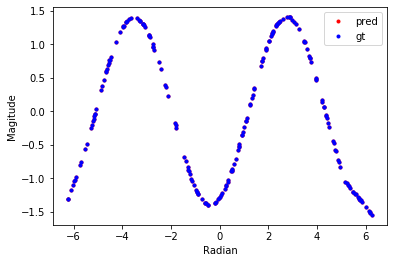

In [7]:
#test visualization and rehspae uitls
item = [support_a[0,:].float(), support_w[0,:].float(), support_x[0,:].float(), support_y[0,:].float()]
utils.taskVisualize(item, sineRegress, shape_record)

In [8]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
print(support_a.size())
dm = support_a.size()[0]

param_dict = {}
param_dict['rho'] = 0.0005
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, sineRegress, param_dict)

torch.Size([3, 10])


197567490239938; m test metric 0.4239786978684027; align loss  0.0009940818417817354
600/2000 o_loss 0.504582657913367; m train metric 0.30652578721443813; m test metric 0.37960355542600155; align loss  0.0010278706904500723
610/2000 o_loss 0.6000284114231667; m train metric 0.3841428130865097; m test metric 0.38927349854599347; align loss  0.0009621262433938682
620/2000 o_loss 0.6896390455464522; m train metric 0.4518804356455803; m test metric 0.3667323341677812; align loss  0.0009292230824939907
630/2000 o_loss 0.5872765436768532; m train metric 0.40556235512097677; m test metric 0.43104523310268467; align loss  0.0009892561938613653
640/2000 o_loss 0.6370888705054919; m train metric 0.4183713215092818; m test metric 0.3826765970072963; align loss  0.0009455105173401535
650/2000 o_loss 0.6770088694989681; m train metric 0.46980499203006426; m test metric 0.3840160232714631; align loss  0.0008793673478066921
660/2000 o_loss 0.4177855471769969; m train metric 0.25194269803663094; m te

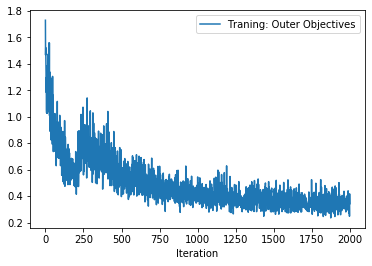

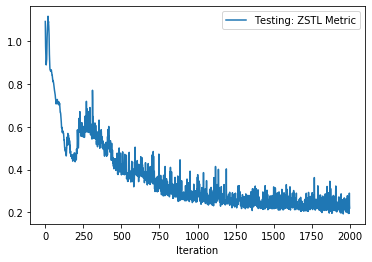

0

In [9]:
ZSTL_model.train(train_loader, test_loader, max_iter=2000)

tensor([1.6000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.75pi, pred loss=0.27517586946487427


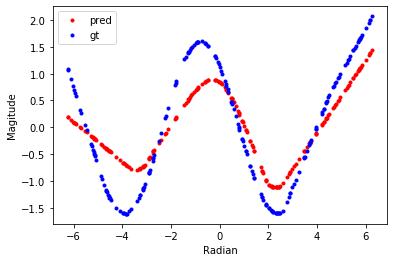

tensor([0.6000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.25pi, pred loss=0.12244755774736404


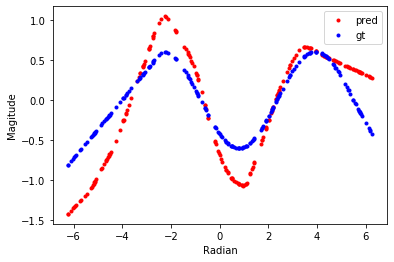

tensor([0.8000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.0pi, pred loss=0.10424236953258514


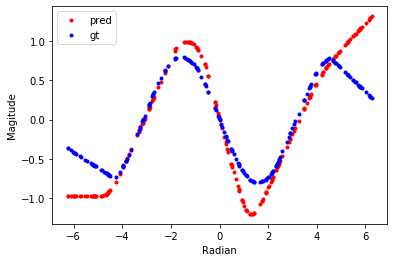

tensor([1.4000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.5pi, pred loss=0.20875047147274017


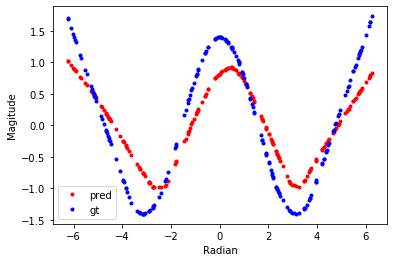

tensor([2.0000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.875pi, pred loss=0.6470617651939392


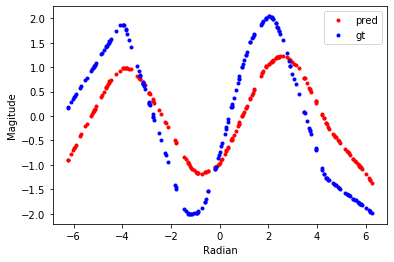

tensor([0.8000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.625pi, pred loss=0.06867866218090057


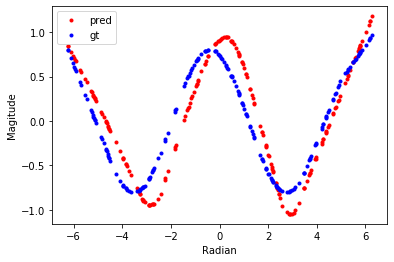

tensor([1.6000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.15504023432731628


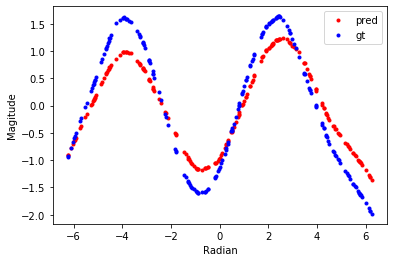

tensor([1.4000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.625pi, pred loss=0.23379258811473846


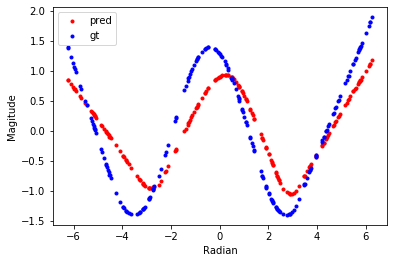

tensor([1.2000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.08060375601053238


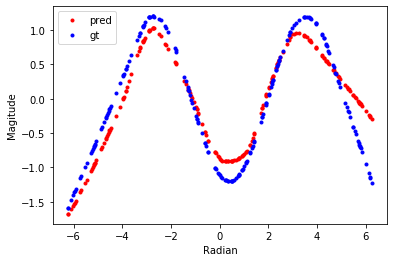

tensor([2.0000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.0pi, pred loss=0.3552664518356323


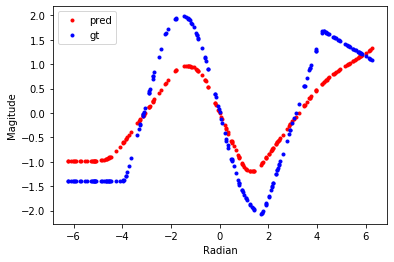

tensor([0.4000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.20193687081336975


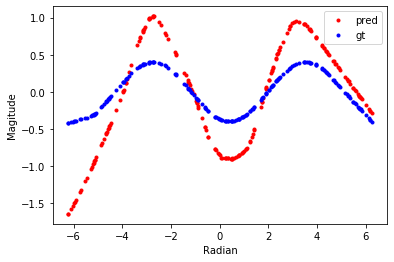

tensor([0.8000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.125pi, pred loss=0.0558299757540226


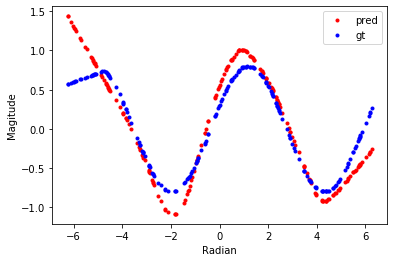

tensor([1.0000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=1.875pi, pred loss=0.18814416229724884


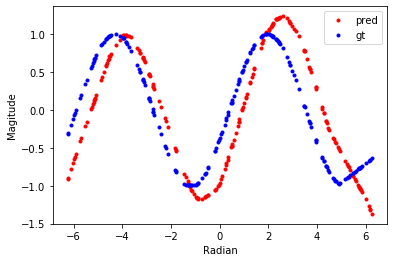

tensor([1.8000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.75pi, pred loss=0.43108606338500977


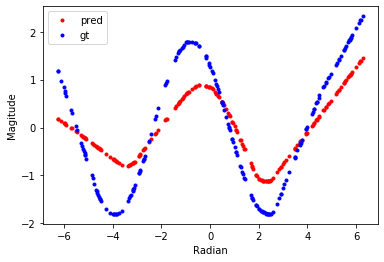

tensor([1.0000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.625pi, pred loss=0.08291960507631302


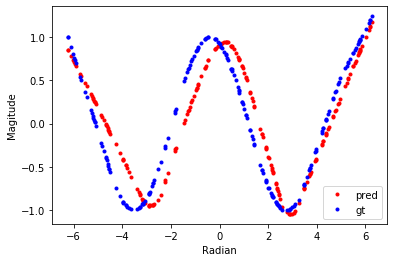

tensor([1.4000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.25pi, pred loss=0.17304189503192902


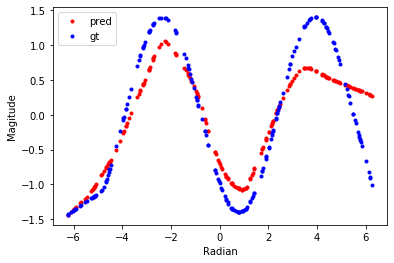

tensor([1.0000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.375pi, pred loss=0.039084818214178085


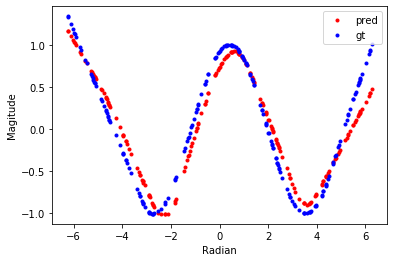

tensor([1.8000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.375pi, pred loss=0.4850258529186249


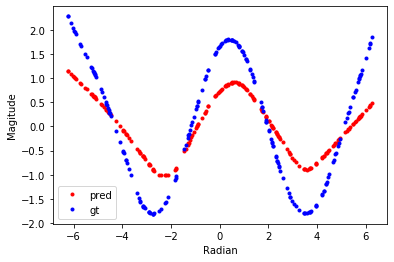

tensor([1.6000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.125pi, pred loss=0.21985484659671783


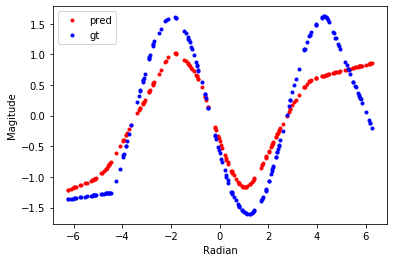

tensor([1.2000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.25pi, pred loss=0.10055769979953766


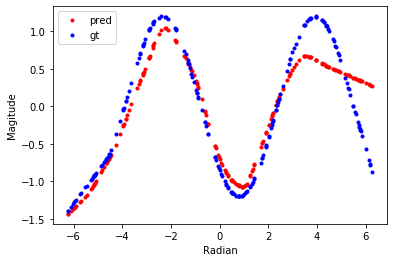

tensor([1.6000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.2044813483953476


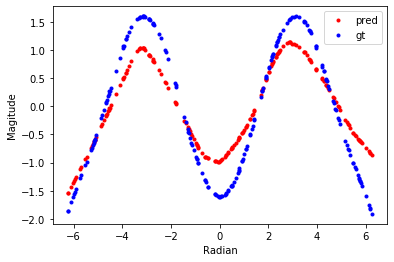

tensor([0.6000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.5pi, pred loss=0.10203031450510025


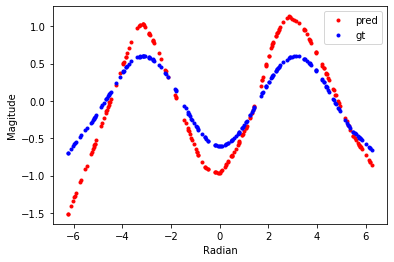

tensor([2.0000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.5pi, pred loss=0.5192171931266785


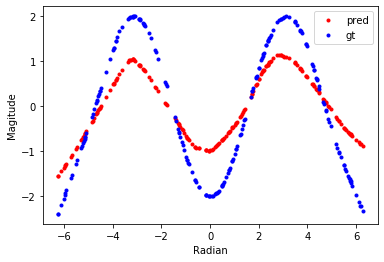

tensor([1.6000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.0pi, pred loss=0.12961673736572266


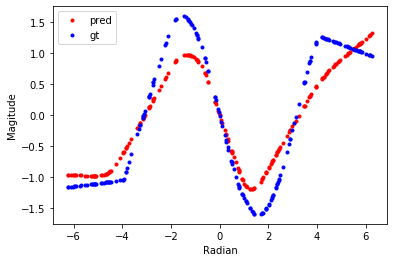

tensor([1.8000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.25pi, pred loss=0.3896332085132599


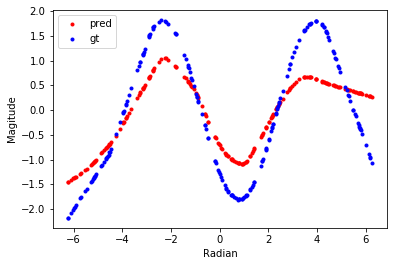

tensor([1.8000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.875pi, pred loss=0.5156830549240112


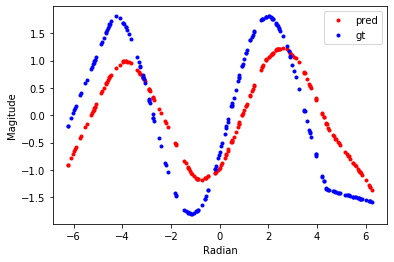

tensor([1.6000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.625pi, pred loss=0.17586322128772736


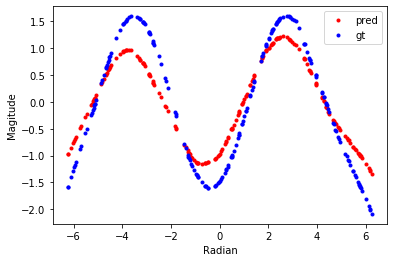

tensor([1.6000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.24831202626228333


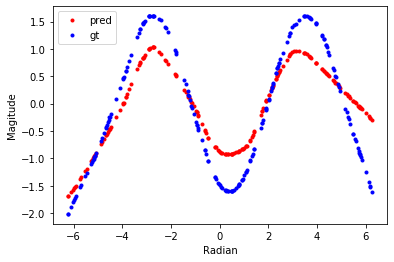

tensor([1.0000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.06819656491279602


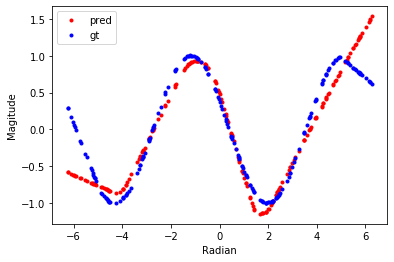

tensor([2.0000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.25pi, pred loss=0.5551437735557556


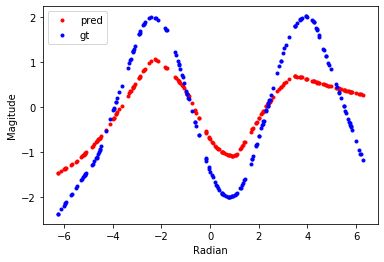

tensor([2.0000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.375pi, pred loss=0.6868409514427185


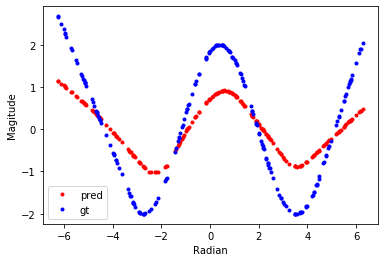

tensor([1.4000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.125pi, pred loss=0.07977280765771866


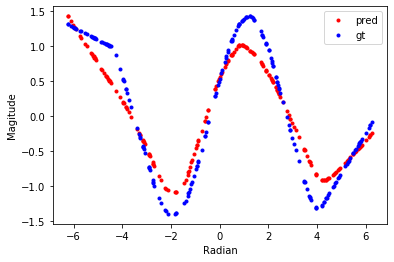

tensor([1.4000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.1447758972644806


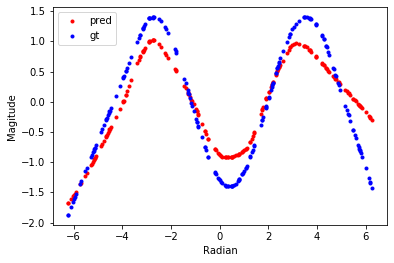

tensor([1.4000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.11790631711483002


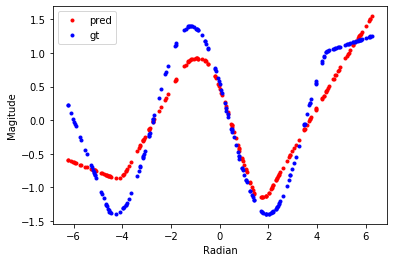

tensor([0.4000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.25pi, pred loss=0.1517685055732727


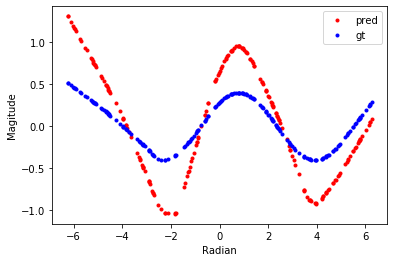

tensor([0.8000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.08663073927164078


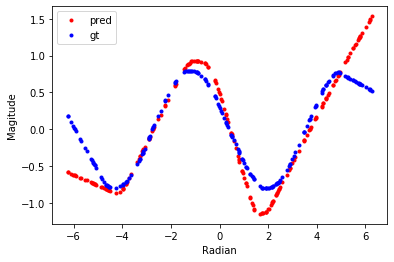

tensor([0.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.125pi, pred loss=0.24730537831783295


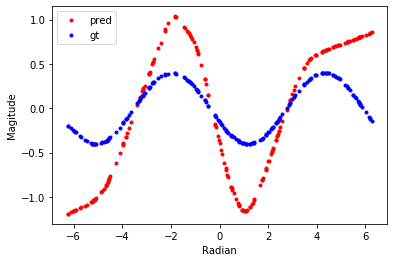

tensor([1.2000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.625pi, pred loss=0.04193692281842232


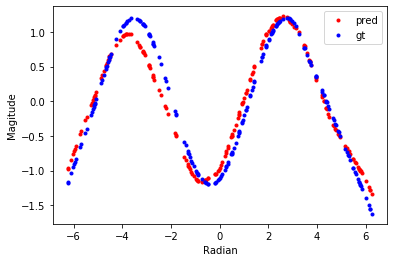

tensor([0.4000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.875pi, pred loss=0.3314080834388733


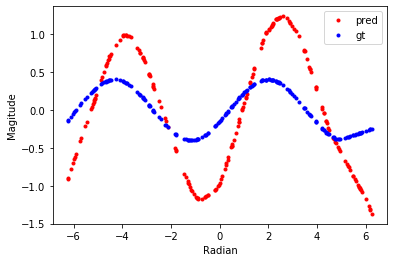

tensor([0.4000, 1.0000, 0.0000])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.0pi, pred loss=0.28584253787994385


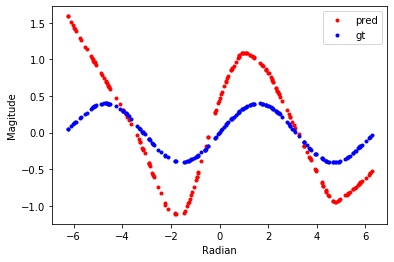

tensor([0.8000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.5pi, pred loss=0.045242395251989365


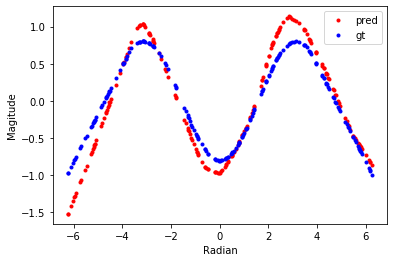

tensor([1.0000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.5pi, pred loss=0.054257553070783615


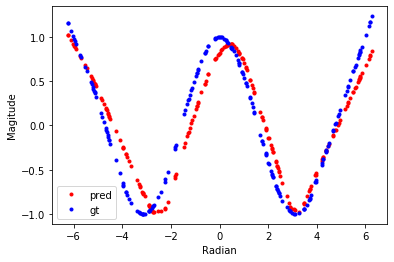

tensor([1.2000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.625pi, pred loss=0.13749293982982635


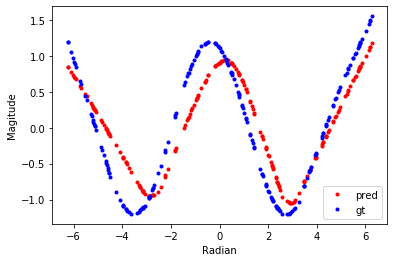

tensor([1.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.125pi, pred loss=0.14619599282741547


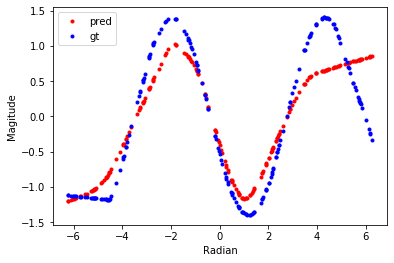

In [10]:
test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

test_w_pred = ZSTL_model.task_transfer(test_a, ZSTL_model.a_kb_opt)
test_batch_size = test_w_pred.size()[1]
tt_w = test_w_pred.clone().detach()


for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  utils.taskVisualize(item, sineRegress, shape_record)